In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib


In [5]:
import pandas as pd

data = pd.read_csv(r"C:\Users\Dell\Documents\Loan project\loan_approval_dataset.csv")
data.fillna(data.mean(), inplace=True)
data['loan_status'] = data['loan_status'].map({' Approved': 1, ' Rejected': 0})


print(data.head())


   loan_id  no_of_dependents      education self_employed  income_annum  \
0        1                 2       Graduate            No       9600000   
1        2                 0   Not Graduate           Yes       4100000   
2        3                 3       Graduate            No       9100000   
3        4                 3       Graduate            No       8200000   
4        5                 5   Not Graduate           Yes       9800000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     29900000         12          778                   2400000   
1     12200000          8          417                   2700000   
2     29700000         20          506                   7100000   
3     30700000          8          467                  18200000   
4     24200000         20          382                  12400000   

   commercial_assets_value  luxury_assets_value  bank_asset_value  loan_status  
0                 17600000             22700000           8

C:\Users\Dell\AppData\Local\Temp\ipykernel_7428\2447817794.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


In [26]:
print(data['loan_status'].unique())


[1 0]


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['education', 'self_employed']
le = LabelEncoder()

for col in categorical_columns:
    data[col] = le.fit_transform(data[col].astype(str))


In [8]:
X = data.drop(['loan_id','loan_status'], axis=1)
y = data['loan_status'] 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
X_train.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
1675,5,1,0,7900000,29900000,6,568,5800000,13900000,15900000,8700000
1164,0,1,1,9600000,34000000,12,710,23800000,10300000,38100000,7800000
192,1,0,0,800000,2900000,8,682,2200000,1100000,2900000,700000
910,2,0,1,4900000,13100000,18,754,8200000,3300000,16500000,7200000
567,5,0,1,3000000,11100000,12,441,8500000,2500000,7300000,2000000


In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'n_estimators': [50, 150],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}


C:\Users\Dell\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:11:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [12]:
# Train the best model
best_model.fit(X_train, y_train)

# Predict on test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


C:\Users\Dell\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:11:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.9789227166276346


In [13]:
joblib.dump(best_model, 'loan_model.pkl')


['loan_model.pkl']

In [2]:
model = joblib.load(r"C:\Users\Dell\Documents\Loan project\loan_model.pkl")

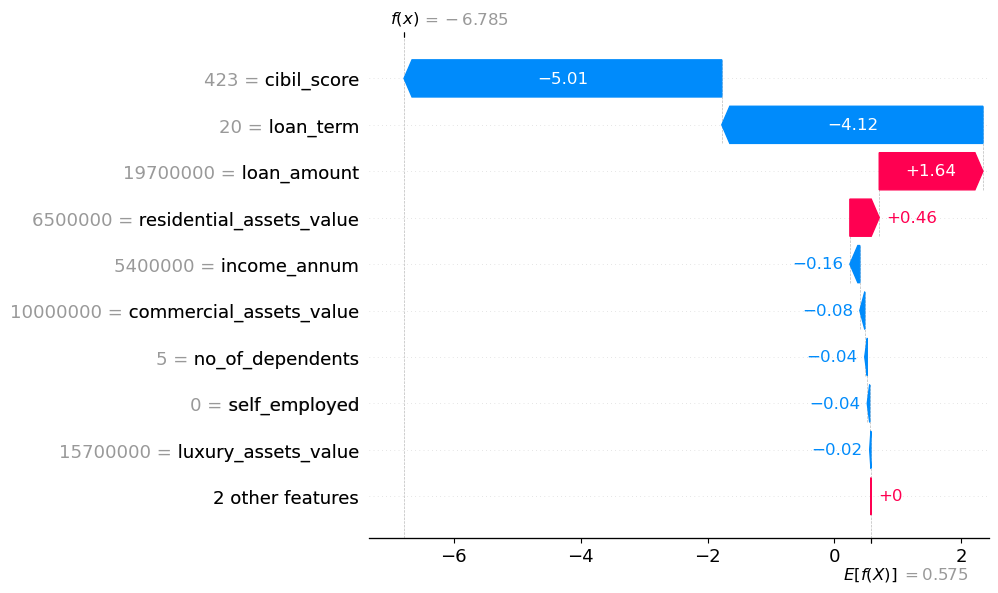

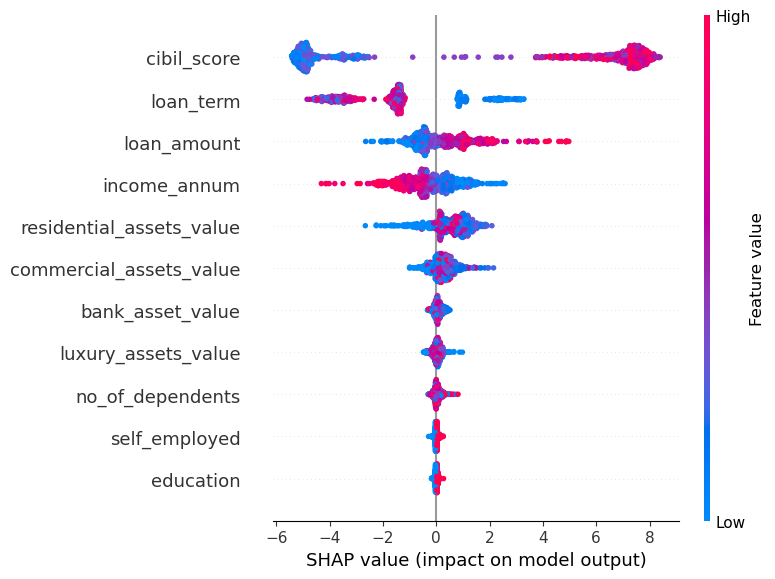

In [9]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[0])

shap.summary_plot(shap_values, X_test, feature_names=X.columns)
